In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import collections
import pickle
from datetime import datetime
from datetime import timedelta

import datetime
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt 

from sklearn import linear_model
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import zero_one_loss
from sklearn.metrics import cohen_kappa_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

##Dataset (FE1: basic count-based feature engineering)

In [0]:
train = pd.read_feather('/content/drive/My Drive/introml/fe/fe1/fe1_train.feather')
#test = pd.read_feather('/content/drive/My Drive/introml/fe/fe1/fe1_test.feather')

In [0]:
le = preprocessing.LabelEncoder()
le.fit(train['installation_id'])
train['installation_id'] = le.transform(train['installation_id'])
train = train.fillna(0)
train = train.drop(['index'], axis=1)

###FE1: Baseline Model

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sb

In [0]:
X = train.drop(columns='accuracy_group')

y = train['accuracy_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

print('Dimensiones x_train: ',X_train.shape)
print('Dimensiones x_test: ',X_test.shape)
print('Dimensiones y_train: ',y_train.shape)
print('Dimensiones y_test: ',y_test.shape)

Dimensiones x_train:  (14152, 36)
Dimensiones x_test:  (3538, 36)
Dimensiones y_train:  (14152,)
Dimensiones y_test:  (3538,)


In [0]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [0]:
n_neighbors = 7

knn = KNeighborsClassifier(n_neighbors)
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.59
Accuracy of K-NN classifier on test set: 0.52


In [0]:
pred = knn.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
print('cohen kappa score:', cohen_kappa_score(y_test, pred))

[[ 387   60   27  384]
 [ 112   57   22  299]
 [  80   35   28  300]
 [ 225   91   64 1367]]
              precision    recall  f1-score   support

           0       0.48      0.45      0.47       858
           1       0.23      0.12      0.16       490
           2       0.20      0.06      0.10       443
           3       0.58      0.78      0.67      1747

    accuracy                           0.52      3538
   macro avg       0.37      0.35      0.35      3538
weighted avg       0.46      0.52      0.48      3538

cohen kappa score: 0.2028434232741062


###FE1: Finetuned Model

([<matplotlib.axis.XTick at 0x7f11b4acfa20>,
 <a list of 5 Text major ticklabel objects>)

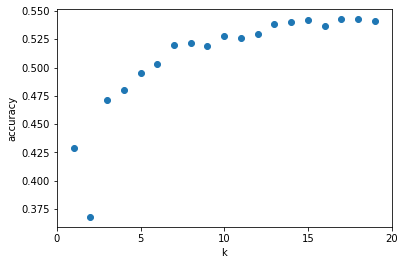

In [0]:
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])

In [0]:
results=pd.DataFrame()
results['k']=list(range(1,20))
results['Scores']=scores

In [0]:
max_value_score=results['Scores'].max()
print('Max. Accuracy: ',max_value_score)
k_max=(results['k'][results['Scores']==max_value_score]).tolist()[0]
print('k value with max. accuracy: ', k_max)

Max. Accuracy:  0.542679479932165
k value with max. accuracy:  17


In [0]:
n_neighbors = k_max

knn = KNeighborsClassifier(n_neighbors)
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.58
Accuracy of K-NN classifier on test set: 0.54


In [0]:
pred = knn.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
print('cohen kappa score:', cohen_kappa_score(y_test, pred))

[[ 339   31    8  480]
 [  81   27    7  375]
 [  59   18    7  359]
 [ 145   37   18 1547]]
              precision    recall  f1-score   support

           0       0.54      0.40      0.46       858
           1       0.24      0.06      0.09       490
           2       0.17      0.02      0.03       443
           3       0.56      0.89      0.69      1747

    accuracy                           0.54      3538
   macro avg       0.38      0.34      0.32      3538
weighted avg       0.46      0.54      0.47      3538

cohen kappa score: 0.19208410986106128


##Dataset (FE2: basic context-based feature engineering)

In [0]:
train = pd.read_feather('/content/drive/My Drive/introml/fe/fe2/fe2_train.feather')
#test = pd.read_feather('/content/drive/My Drive/introml/fe/fe2/fe2_test.feather')

In [0]:
le = preprocessing.LabelEncoder()
le.fit(train['installation_id'])
train['installation_id'] = le.transform(train['installation_id']).astype(int)
train = train.fillna(0)
train['Cauldron Filler (Assessment)_4020_accuracy'] = np.log(train['Cauldron Filler (Assessment)_4020_accuracy'])
train['Mushroom Sorter (Assessment)_4020_accuracy'] = np.log(train['Mushroom Sorter (Assessment)_4020_accuracy'])
train['Bird Measurer (Assessment)_4020_accuracy'] = np.log(train['Bird Measurer (Assessment)_4020_accuracy'])
train['Chest Sorter (Assessment)_4020_accuracy'] = np.log(train['Chest Sorter (Assessment)_4020_accuracy'])

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


###FE2: Baseline Model

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sb

In [0]:
X = train.drop(columns='accuracy_group')

y = train['accuracy_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

print('Dimensiones x_train: ',X_train.shape)
print('Dimensiones x_test: ',X_test.shape)
print('Dimensiones y_train: ',y_train.shape)
print('Dimensiones y_test: ',y_test.shape)

Dimensiones x_train:  (14152, 107)
Dimensiones x_test:  (3538, 107)
Dimensiones y_train:  (14152,)
Dimensiones y_test:  (3538,)


In [0]:
###FOR FE2###
X_train = X_train.replace([np.inf, -np.inf], 0)
X_test = X_test.replace([np.inf, -np.inf], 0)

In [0]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [0]:
n_neighbors = 7

knn = KNeighborsClassifier(n_neighbors)
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.63
Accuracy of K-NN classifier on test set: 0.54


In [0]:
pred = knn.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
print('cohen kappa score:', cohen_kappa_score(y_test, pred))

[[ 420   57   26  323]
 [ 158   62   26  263]
 [  78   25   21  313]
 [ 229   73   58 1406]]
              precision    recall  f1-score   support

           0       0.47      0.51      0.49       826
           1       0.29      0.12      0.17       509
           2       0.16      0.05      0.07       437
           3       0.61      0.80      0.69      1766

    accuracy                           0.54      3538
   macro avg       0.38      0.37      0.36      3538
weighted avg       0.48      0.54      0.49      3538

cohen kappa score: 0.2364437479928735


###FE2: Finetuned Model

([<matplotlib.axis.XTick at 0x7f11b4bbe2b0>,
 <a list of 5 Text major ticklabel objects>)

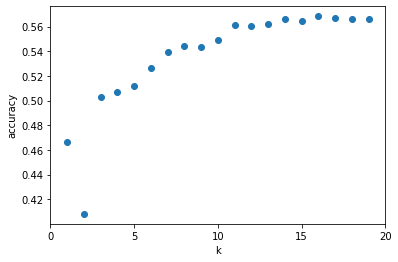

In [0]:
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])

In [0]:
results=pd.DataFrame()
results['k']=list(range(1,20))
results['Scores']=scores

In [0]:
max_value_score=results['Scores'].max()
print('Max. Accuracy: ',max_value_score)
k_max=(results['k'][results['Scores']==max_value_score]).tolist()[0]
print('k value with max. accuracy: ', k_max)

Max. Accuracy:  0.56840022611645
k value with max. accuracy:  16


In [0]:
n_neighbors = k_max

knn = KNeighborsClassifier(n_neighbors)
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.60
Accuracy of K-NN classifier on test set: 0.57


In [0]:
pred = knn.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
print('cohen kappa score:', cohen_kappa_score(y_test, pred))

[[ 404   25   14  383]
 [ 170   31   14  294]
 [  66   15   11  345]
 [ 169   24    8 1565]]
              precision    recall  f1-score   support

           0       0.50      0.49      0.49       826
           1       0.33      0.06      0.10       509
           2       0.23      0.03      0.05       437
           3       0.60      0.89      0.72      1766

    accuracy                           0.57      3538
   macro avg       0.42      0.37      0.34      3538
weighted avg       0.49      0.57      0.49      3538

cohen kappa score: 0.25086380776502093


##Dataset (F3: final improved context-based feature engineering)

In [0]:
train = pickle.load(open('/content/drive/My Drive/introml/fe/fe3/fe3_train.pkl', 'rb'))
#test = pickle.load(open('/content/drive/My Drive/introml/fe/fe3/fe3_test.pkl', 'rb'))

In [0]:
train.drop('last_activity_timestamp', axis=1, inplace=True)
train.drop('last_game_timestamp', axis=1, inplace=True)
train.drop('last_assessment_timestamp', axis=1, inplace=True)
train = train.fillna(0)

###FE3: Baseline Model

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sb

In [0]:
X = train.drop(columns='accuracy_group')

y = train['accuracy_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

print('Dimensiones x_train: ',X_train.shape)
print('Dimensiones x_test: ',X_test.shape)
print('Dimensiones y_train: ',y_train.shape)
print('Dimensiones y_test: ',y_test.shape)

Dimensiones x_train:  (14152, 513)
Dimensiones x_test:  (3538, 513)
Dimensiones y_train:  (14152,)
Dimensiones y_test:  (3538,)


In [0]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [0]:
n_neighbors = 7

knn = KNeighborsClassifier(n_neighbors)
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.62
Accuracy of K-NN classifier on test set: 0.49


In [0]:
pred = knn.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
print('cohen kappa score:', cohen_kappa_score(y_test, pred))

[[ 304   34   23  497]
 [  85   34   19  352]
 [  66   28   22  327]
 [ 221   78   71 1377]]
              precision    recall  f1-score   support

           0       0.45      0.35      0.40       858
           1       0.20      0.07      0.10       490
           2       0.16      0.05      0.08       443
           3       0.54      0.79      0.64      1747

    accuracy                           0.49      3538
   macro avg       0.34      0.32      0.30      3538
weighted avg       0.42      0.49      0.44      3538

cohen kappa score: 0.1309745399793789


###FE3: Finetuned Model

([<matplotlib.axis.XTick at 0x7f11b4ae4080>,
 <a list of 5 Text major ticklabel objects>)

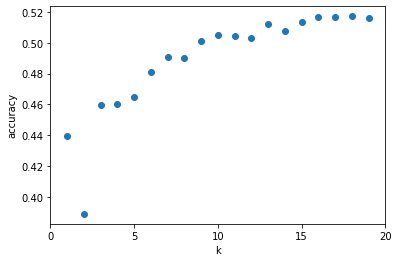

In [0]:
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])

In [0]:
results=pd.DataFrame()
results['k']=list(range(1,20))
results['Scores']=scores

In [0]:
max_value_score=results['Scores'].max()
print('Max. Accuracy: ',max_value_score)
k_max=(results['k'][results['Scores']==max_value_score]).tolist()[0]
print('k value with max. accuracy: ', k_max)

Max. Accuracy:  0.5172413793103449
k value with max. accuracy:  18


In [0]:
n_neighbors = k_max

knn = KNeighborsClassifier(n_neighbors)
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.57
Accuracy of K-NN classifier on test set: 0.52


In [0]:
pred = knn.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
print('cohen kappa score:', cohen_kappa_score(y_test, pred))

[[ 212   15    4  627]
 [  51    8    4  427]
 [  37   11    6  389]
 [  99   29   15 1604]]
              precision    recall  f1-score   support

           0       0.53      0.25      0.34       858
           1       0.13      0.02      0.03       490
           2       0.21      0.01      0.03       443
           3       0.53      0.92      0.67      1747

    accuracy                           0.52      3538
   macro avg       0.35      0.30      0.27      3538
weighted avg       0.43      0.52      0.42      3538

cohen kappa score: 0.1124178867014205


##Remove Correlated Features

In [0]:
def remove_correlated_features(train, features):
    counter = 0
    to_remove = []
    for feat_a in features:
        for feat_b in features:
            if feat_a != feat_b and feat_a not in to_remove and feat_b not in to_remove:
                c = np.corrcoef(train[feat_a], train[feat_b])[0][1]
                if c > 0.9999:
                    counter += 1
                    to_remove.append(feat_a)
                    print('{}: FEAT_A: {} FEAT_B: {} - Correlation: {}'.format(counter, feat_a, feat_b, c))
    return to_remove

In [0]:
remove_correlated_features(train, list(train.columns))

1: FEAT_A: b2dba42b FEAT_B: 1bb5fbdb - Correlation: 0.9999405639639954
2: FEAT_A: dcaede90 FEAT_B: 2040 - Correlation: 1.0
3: FEAT_A: f71c4741 FEAT_B: f7e47413 - Correlation: 0.9999464999851319
4: FEAT_A: 2b9272f4 FEAT_B: 37c53127 - Correlation: 0.9999777600181912
5: FEAT_A: 37c53127 FEAT_B: 2050 - Correlation: 1.0
6: FEAT_A: d88e8f25 FEAT_B: ac92046e - Correlation: 0.9999716958360618
7: FEAT_A: c277e121 FEAT_B: b120f2ac - Correlation: 0.9999845666155784
8: FEAT_A: 3bfd1a65 FEAT_B: db02c830 - Correlation: 0.9999982079383459
9: FEAT_A: 9d29771f FEAT_B: c74f40cd - Correlation: 0.9999444921075749
10: FEAT_A: 83c6c409 FEAT_B: 3dfd4aa4 - Correlation: 0.9999827146479853
11: FEAT_A: f28c589a FEAT_B: a1bbe385 - Correlation: 0.9999559134451931
12: FEAT_A: 5154fc30 FEAT_B: 3babcb9b - Correlation: 0.9999824088485433
13: FEAT_A: 0a08139c FEAT_B: 71fe8f75 - Correlation: 0.9999762369223734
14: FEAT_A: a6d66e51 FEAT_B: 5000 - Correlation: 0.9999999999999998
15: FEAT_A: 71e712d8 FEAT_B: 5010 - Correla

['b2dba42b',
 'dcaede90',
 'f71c4741',
 '2b9272f4',
 '37c53127',
 'd88e8f25',
 'c277e121',
 '3bfd1a65',
 '9d29771f',
 '83c6c409',
 'f28c589a',
 '5154fc30',
 '0a08139c',
 'a6d66e51',
 '71e712d8',
 '1996c610',
 'c54cf6c5',
 '1340b8d7',
 '160654fd',
 '45d01abe',
 'ad148f58',
 '85de926c',
 '7ad3efc6',
 'ecaab346',
 'b74258a0',
 '907a054b',
 '9b23e8ee',
 '5b49460a',
 'ea296733',
 'a1192f43',
 'b012cd7f',
 '1c178d24',
 '38074c54',
 3010,
 3021,
 4230,
 'Cauldron Filler (Assessment)_4020_accuracy',
 'last_activity_event_count',
 'last_game_event_count',
 'last_assessment_event_count']

In [0]:
corr_features = ['b2dba42b',
 'dcaede90',
 'f71c4741',
 '2b9272f4',
 '37c53127',
 'd88e8f25',
 'c277e121',
 '3bfd1a65',
 '9d29771f',
 '83c6c409',
 'f28c589a',
 '5154fc30',
 '0a08139c',
 'a6d66e51',
 '71e712d8',
 '1996c610',
 'c54cf6c5',
 '1340b8d7',
 '160654fd',
 '45d01abe',
 'ad148f58',
 '85de926c',
 '7ad3efc6',
 'ecaab346',
 'b74258a0',
 '907a054b',
 '9b23e8ee',
 '5b49460a',
 'ea296733',
 'a1192f43',
 'b012cd7f',
 '1c178d24',
 '38074c54',
 3010,
 3021,
 4230,
 'Cauldron Filler (Assessment)_4020_accuracy',
 'last_activity_event_count',
 'last_game_event_count',
 'last_assessment_event_count']

In [0]:
train_removed = train.drop(corr_features, axis=1)

In [0]:
X_removed = train_removed.drop(columns='accuracy_group').values

y_removed = train_removed['accuracy_group'].values

X_train_removed, X_test_removed, y_train_removed, y_test_removed = train_test_split(X_removed, y_removed, random_state=1)

print('Dimensiones x_train: ',X_train_removed.shape)
print('Dimensiones x_test: ',X_test_removed.shape)
print('Dimensiones y_train: ',y_train_removed.shape)
print('Dimensiones y_test: ',y_test_removed.shape)

Dimensiones x_train:  (13267, 473)
Dimensiones x_test:  (4423, 473)
Dimensiones y_train:  (13267,)
Dimensiones y_test:  (4423,)


In [0]:
scaler = MinMaxScaler()
X_train_removed = scaler.fit_transform(X_train_removed)
X_test_removed = scaler.transform(X_test_removed)

In [0]:
n_neighbors = 7

knn = KNeighborsClassifier(n_neighbors)
knn.fit(X_train_removed, y_train_removed)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train_removed, y_train_removed)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test_removed, y_test_removed)))

Accuracy of K-NN classifier on training set: 0.62
Accuracy of K-NN classifier on test set: 0.51


In [0]:
pred = knn.predict(X_test_removed)
print(confusion_matrix(y_test_removed, pred))
print(classification_report(y_test_removed, pred))
print('cohen kappa score:', cohen_kappa_score(y_test_removed, pred))

[[ 422   46   28  582]
 [ 100   70   23  389]
 [  81   48   30  409]
 [ 284   92   88 1731]]
              precision    recall  f1-score   support

           0       0.48      0.39      0.43      1078
           1       0.27      0.12      0.17       582
           2       0.18      0.05      0.08       568
           3       0.56      0.79      0.65      2195

    accuracy                           0.51      4423
   macro avg       0.37      0.34      0.33      4423
weighted avg       0.45      0.51      0.46      4423

cohen kappa score: 0.16779544535846969


Finetuned Model

([<matplotlib.axis.XTick at 0x7f11b4d0f860>,
 <a list of 5 Text major ticklabel objects>)

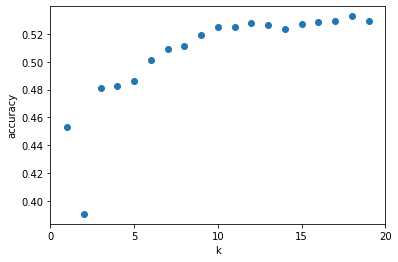

In [0]:
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train_removed, y_train_removed)
    scores.append(knn.score(X_test_removed, y_test_removed))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])

In [0]:
results=pd.DataFrame()
results['k']=list(range(1,20))
results['Scores']=scores

In [0]:
max_value_score=results['Scores'].max()
print('Max. Accuracy: ',max_value_score)
k_max=(results['k'][results['Scores']==max_value_score]).tolist()[0]
print('k value with max. accuracy: ', k_max)

Max. Accuracy:  0.5326701333936242
k value with max. accuracy:  18


In [0]:
n_neighbors = k_max

knn = KNeighborsClassifier(n_neighbors)
knn.fit(X_train_removed, y_train_removed)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train_removed, y_train_removed)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test_removed, y_test_removed)))

Accuracy of K-NN classifier on training set: 0.56
Accuracy of K-NN classifier on test set: 0.53


In [0]:
pred = knn.predict(X_test_removed)
print(confusion_matrix(y_test_removed, pred))
print(classification_report(y_test_removed, pred))
print('cohen kappa score:', cohen_kappa_score(y_test_removed, pred))

[[ 289    7    8  774]
 [  61   26    6  489]
 [  44   12    5  507]
 [ 121   28   10 2036]]
              precision    recall  f1-score   support

           0       0.56      0.27      0.36      1078
           1       0.36      0.04      0.08       582
           2       0.17      0.01      0.02       568
           3       0.53      0.93      0.68      2195

    accuracy                           0.53      4423
   macro avg       0.41      0.31      0.28      4423
weighted avg       0.47      0.53      0.44      4423

cohen kappa score: 0.13707792182663092


##Feature Selection

In [0]:
from sklearn.decomposition import PCA
pca = PCA(.95) #change the variance accordingly
pca.fit(X_train_removed)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [0]:
X_train_removed = pca.fit_transform(X_train_removed)
X_test_removed = pca.transform(X_test_removed)

In [0]:
n_neighbors = 7

knn = KNeighborsClassifier(n_neighbors)
knn.fit(X_train_removed, y_train_removed)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train_removed, y_train_removed)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test_removed, y_test_removed)))

Accuracy of K-NN classifier on training set: 0.63
Accuracy of K-NN classifier on test set: 0.51


In [0]:
pred = knn.predict(X_test_removed)
print(confusion_matrix(y_test_removed, pred))
print(classification_report(y_test_removed, pred))
print('cohen kappa score:', cohen_kappa_score(y_test_removed, pred))

[[ 461   73   33  511]
 [ 144   86   31  321]
 [  96   70   35  367]
 [ 310  115   83 1687]]
              precision    recall  f1-score   support

           0       0.46      0.43      0.44      1078
           1       0.25      0.15      0.19       582
           2       0.19      0.06      0.09       568
           3       0.58      0.77      0.66      2195

    accuracy                           0.51      4423
   macro avg       0.37      0.35      0.35      4423
weighted avg       0.46      0.51      0.47      4423

cohen kappa score: 0.194983538685378


([<matplotlib.axis.XTick at 0x7f11b469eac8>,
 <a list of 5 Text major ticklabel objects>)

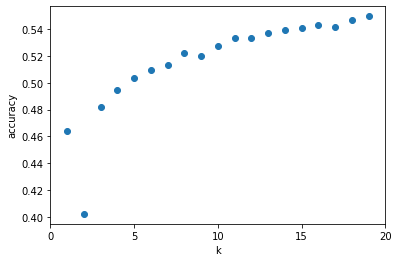

In [0]:
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train_removed, y_train_removed)
    scores.append(knn.score(X_test_removed, y_test_removed))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])

In [0]:
results=pd.DataFrame()
results['k']=list(range(1,20))
results['Scores']=scores

In [0]:
max_value_score=results['Scores'].max()
print('Max. Accuracy: ',max_value_score)
k_max=(results['k'][results['Scores']==max_value_score]).tolist()[0]
print('k value with max. accuracy: ', k_max)

Max. Accuracy:  0.5494008591453764
k value with max. accuracy:  19


In [0]:
n_neighbors = k_max

knn = KNeighborsClassifier(n_neighbors)
knn.fit(X_train_removed, y_train_removed)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train_removed, y_train_removed)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test_removed, y_test_removed)))

Accuracy of K-NN classifier on training set: 0.58
Accuracy of K-NN classifier on test set: 0.55


In [0]:
pred = knn.predict(X_test_removed)
print(confusion_matrix(y_test_removed, pred))
print(classification_report(y_test_removed, pred))
print('cohen kappa score:', cohen_kappa_score(y_test_removed, pred))

[[ 402   26   10  640]
 [ 105   42   11  424]
 [  64   31   16  457]
 [ 176   41    8 1970]]
              precision    recall  f1-score   support

           0       0.54      0.37      0.44      1078
           1       0.30      0.07      0.12       582
           2       0.36      0.03      0.05       568
           3       0.56      0.90      0.69      2195

    accuracy                           0.55      4423
   macro avg       0.44      0.34      0.33      4423
weighted avg       0.50      0.55      0.47      4423

cohen kappa score: 0.19774873729031195
